In [99]:
!pip install gradio transformers
!pip install mlflow pyngrok
!pip install emoji

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import missingno as msno
from wordcloud import WordCloud
import string
from transformers import BertTokenizer, TFBertForSequenceClassification
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import pickle
import kagglehub
import gradio as gr
from pyngrok import ngrok
import mlflow
import mlflow.tensorflow
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import emoji

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
# Download latest version
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-dataset


## Import the data

In [103]:
!ls {path}

test.csv			train.csv
testdata.manual.2009.06.14.csv	training.1600000.processed.noemoticon.csv


In [104]:
train_df = pd.read_csv(path + "/train.csv", encoding="latin-1")
test_df = pd.read_csv(path + "/test.csv", encoding="latin-1")

In [105]:
df = pd.concat([train_df, test_df], ignore_index= True)
df

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0
...,...,...,...,...,...,...,...,...,...,...
32291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Hala

## EDA Plots

In [106]:
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32296 entries, 0 to 32295
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.5+ MB
None

First 5 rows:
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                        

In [107]:
df = df.dropna(subset=['text', 'sentiment'])
print("\nMissing Values After Dropping Rows with Missing 'text' or 'sentiment':")
print(df.isnull().sum())


Missing Values After Dropping Rows with Missing 'text' or 'sentiment':
textID                 0
text                   0
selected_text       3534
sentiment              0
Time of Tweet          0
Age of User            0
Country                0
Population -2020       0
Land Area (Km²)        0
Density (P/Km²)        0
dtype: int64


In [108]:
df['selected_text'] = df.apply(lambda row: row['text'] if pd.isna(row['selected_text']) else row['selected_text'], axis=1)
df['selected_text'] = df['selected_text'].fillna('')

<ipython-input-108-00945603fbc1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selected_text'] = df.apply(lambda row: row['text'] if pd.isna(row['selected_text']) else row['selected_text'], axis=1)
<ipython-input-108-00945603fbc1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selected_text'] = df['selected_text'].fillna('')


In [109]:
df['textID'] = df['textID'].fillna('Unknown')
df['Time of Tweet'] = df['Time of Tweet'].fillna('Unknown')
df['Age of User'] = df['Age of User'].fillna('Unknown')
df['Country'] = df['Country'].fillna('Unknown')
df['Population -2020'] = df['Population -2020'].fillna(df['Population -2020'].mean())
df['Land Area (Km²)'] = df['Land Area (Km²)'].fillna(df['Land Area (Km²)'].mean())
df['Density (P/Km²)'] = df['Density (P/Km²)'].fillna(df['Density (P/Km²)'].mean())
print("\nMissing Values After Handling All Columns:")
print(df.isnull().sum())


Missing Values After Handling All Columns:
textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


<ipython-input-109-b4065901a9a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['textID'] = df['textID'].fillna('Unknown')
<ipython-input-109-b4065901a9a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time of Tweet'] = df['Time of Tweet'].fillna('Unknown')
<ipython-input-109-b4065901a9a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

<ipython-input-110-01a97f89fefd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str).fillna('')
<ipython-input-110-01a97f89fefd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selected_text'] = df['selected_text'].astype(str).fillna('')
<ipython-input-110-01a97f89fefd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda


Text Length Statistics:
count    31014.000000
mean        68.289160
std         35.620474
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        159.000000
Name: text_length, dtype: float64

Selected Text Length Statistics:
count    31014.000000
mean        40.225705
std         37.013019
min          1.000000
25%          9.000000
50%         27.000000
75%         62.000000
max        158.000000
Name: selected_text_length, dtype: float64


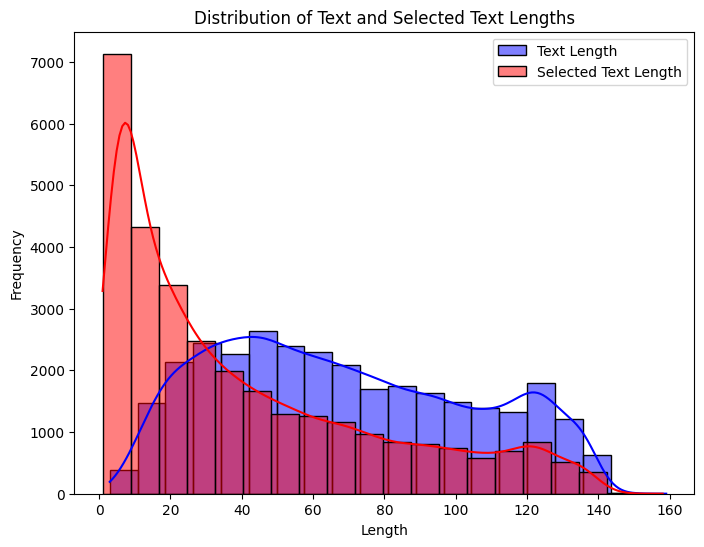

In [110]:
df['text'] = df['text'].astype(str).fillna('')
df['selected_text'] = df['selected_text'].astype(str).fillna('')
df['text_length'] = df['text'].apply(lambda x: len(x) if isinstance(x, str) and x != 'nan' else 0)
df['selected_text_length'] = df['selected_text'].apply(lambda x: len(x) if isinstance(x, str) and x != 'nan' else 0)
print("\nText Length Statistics:")
print(df['text_length'].describe())
print("\nSelected Text Length Statistics:")
print(df['selected_text_length'].describe())
plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], bins=20, kde=True, color='blue', label='Text Length')
sns.histplot(df['selected_text_length'], bins=20, kde=True, color='red', label='Selected Text Length')
plt.title('Distribution of Text and Selected Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Sentiment Distribution:
sentiment
neutral     12547
positive     9685
negative     8782
Name: count, dtype: int64


<ipython-input-111-7f717b676ba6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


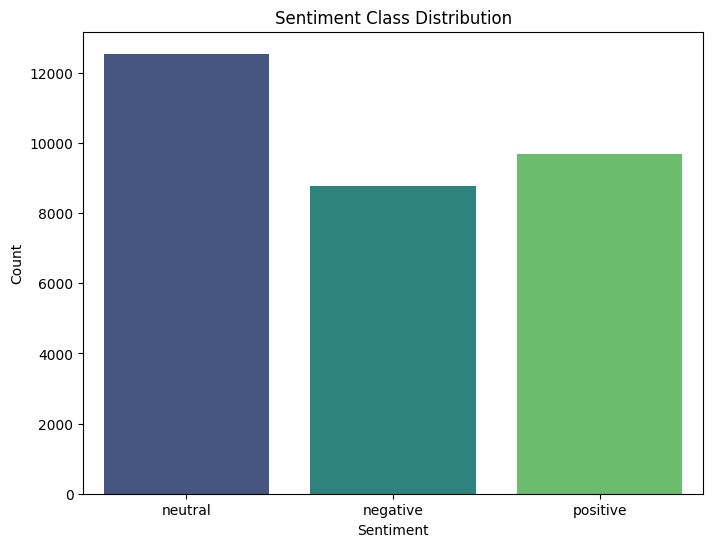

In [111]:
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-112-02830fbf16ad>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_tokens'] = df['text'].apply(preprocess_text)
<ipython-input-112-02830fbf16ad>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u


Text Word Count Statistics (after preprocessing):
count    31014.000000
mean         7.436351
std          4.031923
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         28.000000
Name: text_word_count, dtype: float64

Selected Text Word Count Statistics (after preprocessing):
count    31014.000000
mean         4.537048
std          4.016664
min          0.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         25.000000
Name: selected_text_word_count, dtype: float64


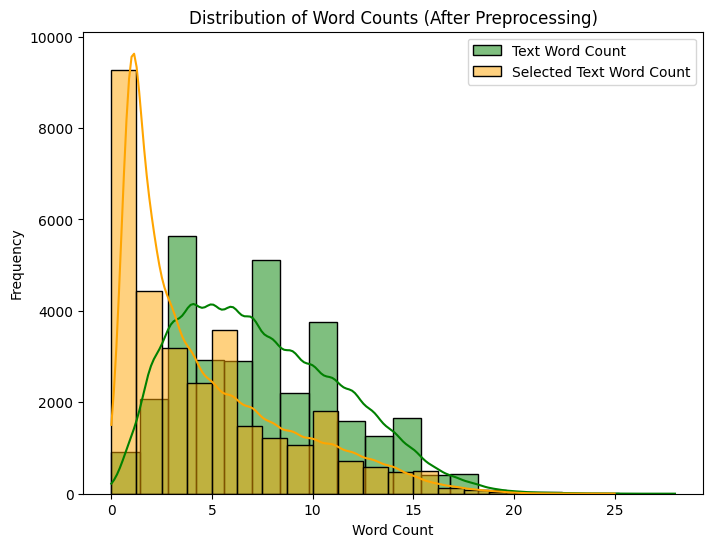

In [112]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def preprocess_text(text):
    if not isinstance(text, str) or text == 'nan':
        return []
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    return tokens

df['text_tokens'] = df['text'].apply(preprocess_text)
df['selected_text_tokens'] = df['selected_text'].apply(preprocess_text)
df['text_word_count'] = df['text_tokens'].apply(len)
df['selected_text_word_count'] = df['selected_text_tokens'].apply(len)
print("\nText Word Count Statistics (after preprocessing):")
print(df['text_word_count'].describe())
print("\nSelected Text Word Count Statistics (after preprocessing):")
print(df['selected_text_word_count'].describe())
plt.figure(figsize=(8, 6))
sns.histplot(df['text_word_count'], bins=20, kde=True, color='green', label='Text Word Count')
sns.histplot(df['selected_text_word_count'], bins=20, kde=True, color='orange', label='Selected Text Word Count')
plt.title('Distribution of Word Counts (After Preprocessing)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Top 10 Most Common Words in Text:
[('...', 4343), ('day', 2312), ('..', 1892), ('good', 1779), ('get', 1589), ('like', 1514), ('go', 1431), ('http', 1419), ('got', 1416), ('love', 1298)]

Top 10 Most Common Words in Selected Text:
[('...', 2237), ('good', 1462), ('day', 1300), ('..', 1277), ('love', 1070), ('happy', 970), ('like', 940), ('get', 934), ('go', 861), ('got', 830)]


<ipython-input-113-c3c17ca16955>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='magma')


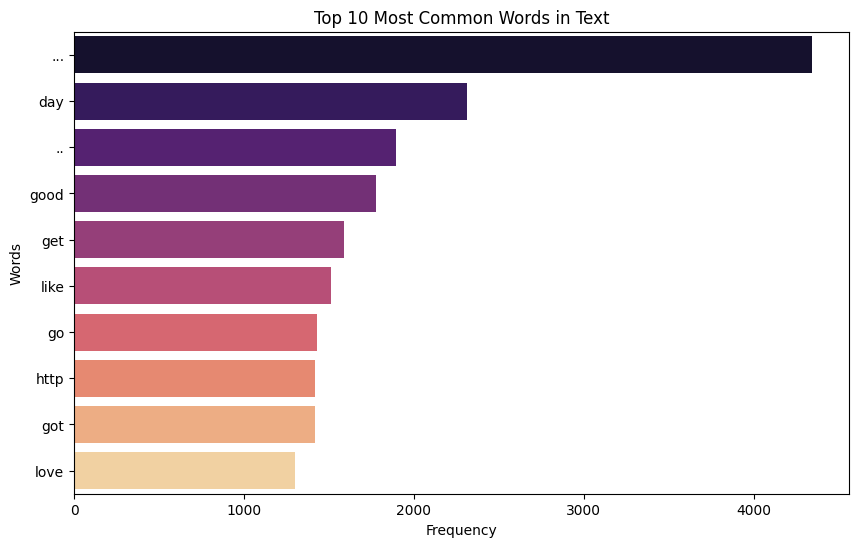

<ipython-input-113-c3c17ca16955>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='magma')


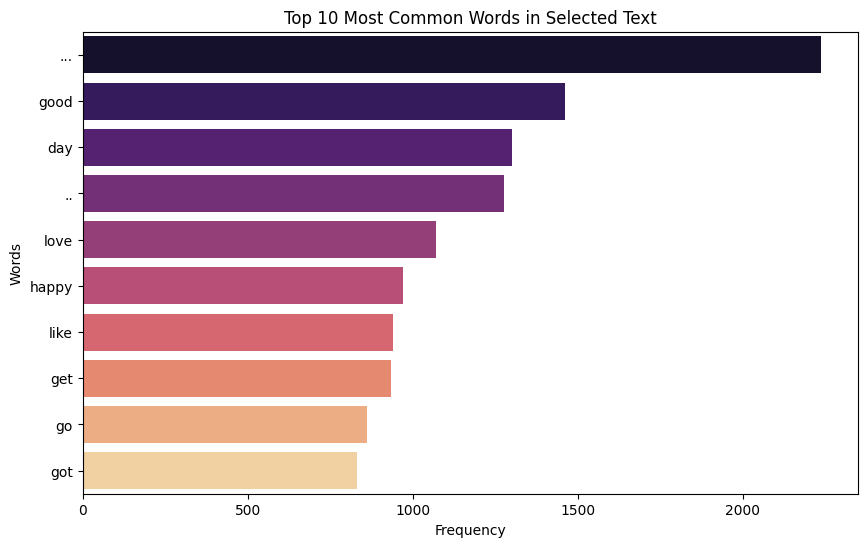

In [113]:
all_text_words = [word for tokens in df['text_tokens'] for word in tokens]
text_word_freq = Counter(all_text_words)
common_text_words = text_word_freq.most_common(10)
print("\nTop 10 Most Common Words in Text:")
print(common_text_words)

all_selected_words = [word for tokens in df['selected_text_tokens'] for word in tokens]
selected_word_freq = Counter(all_selected_words)
common_selected_words = selected_word_freq.most_common(10)
print("\nTop 10 Most Common Words in Selected Text:")
print(common_selected_words)

if common_text_words:
    words, counts = zip(*common_text_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words, palette='magma')
    plt.title('Top 10 Most Common Words in Text')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

if common_selected_words:
    words, counts = zip(*common_selected_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words, palette='magma')
    plt.title('Top 10 Most Common Words in Selected Text')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

<ipython-input-114-44ff03ca6e89>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='text_length', data=df, palette='coolwarm')


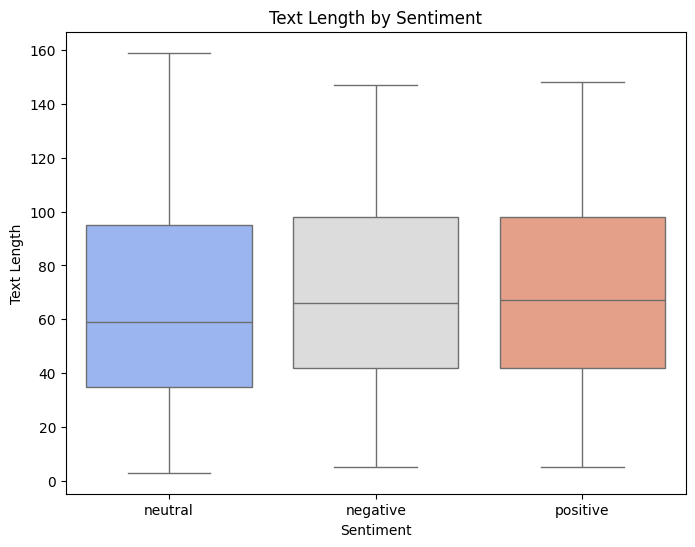

<ipython-input-114-44ff03ca6e89>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='text_word_count', data=df, palette='coolwarm')


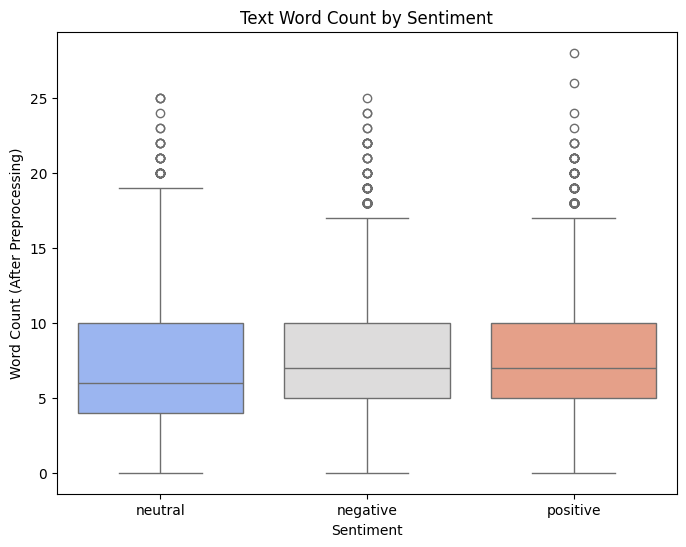

<ipython-input-114-44ff03ca6e89>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='Population -2020', data=df, palette='viridis')


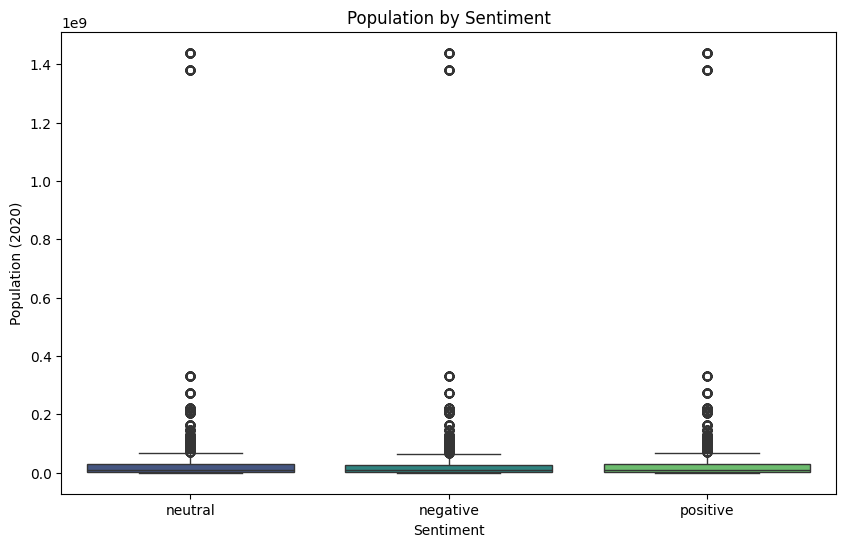

In [114]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='text_length', data=df, palette='coolwarm')
plt.title('Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='text_word_count', data=df, palette='coolwarm')
plt.title('Text Word Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count (After Preprocessing)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='Population -2020', data=df, palette='viridis')
plt.title('Population by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Population (2020)')
plt.show()

### Marwan

Text(0.5, 1.0, 'Most Common Words')

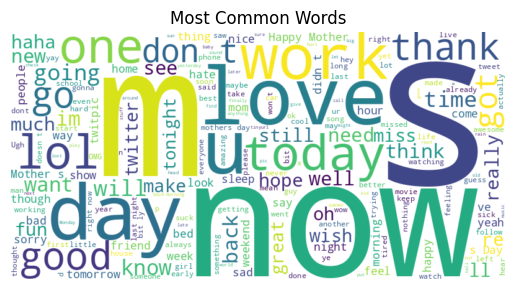

In [115]:
from collections import Counter
from wordcloud import WordCloud

all_words = ' '.join(df['text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words")


In [116]:
print("Count per sentiment:")
print(df['sentiment'].value_counts())


for sentiment in df['sentiment'].unique():
    empty_count = df[(df['sentiment'] == sentiment) & (df['text'].isnull() | (df['text'].str.strip() == ''))].shape[0]
    print(f"Empty text rows for '{sentiment}': {empty_count}")

Count per sentiment:
sentiment
neutral     12547
positive     9685
negative     8782
Name: count, dtype: int64
Empty text rows for 'neutral': 0
Empty text rows for 'negative': 0
Empty text rows for 'positive': 0


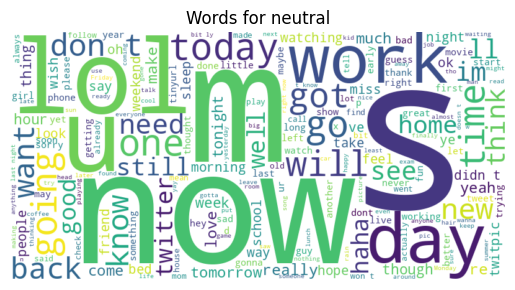

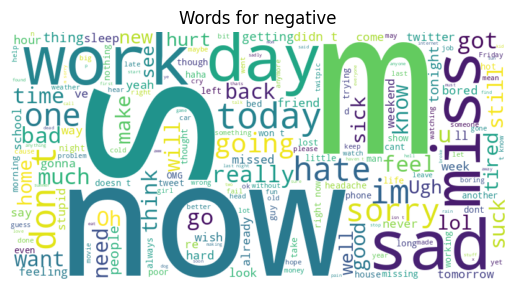

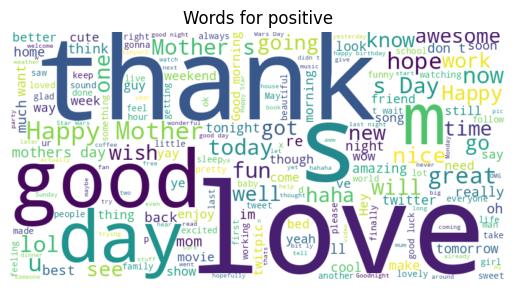

In [117]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for sentiment in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment'] == sentiment]['text'].dropna().astype(str))

    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Words for {sentiment}")
        plt.show()
    else:
        print(f"No text data found for sentiment '{sentiment}'. Skipping word cloud.")

<Axes: xlabel='sentiment', ylabel='text'>

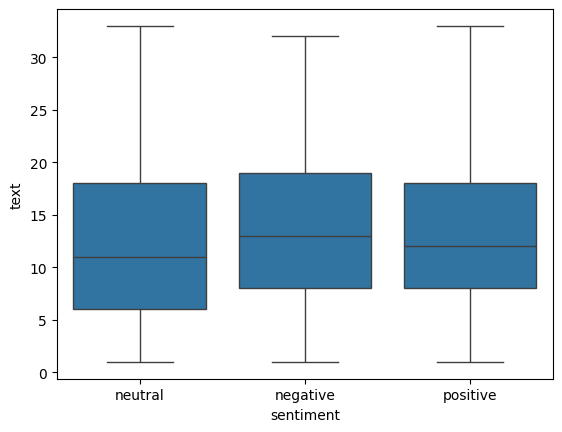

In [118]:
sns.boxplot(x='sentiment', y= df['text'].astype(str).apply(lambda x: len(x.split())), data=df)

<Axes: >

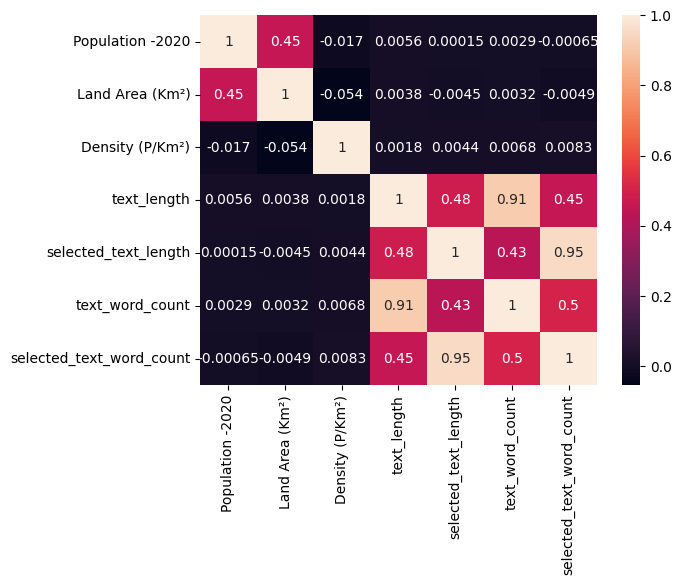

In [119]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

### Malak

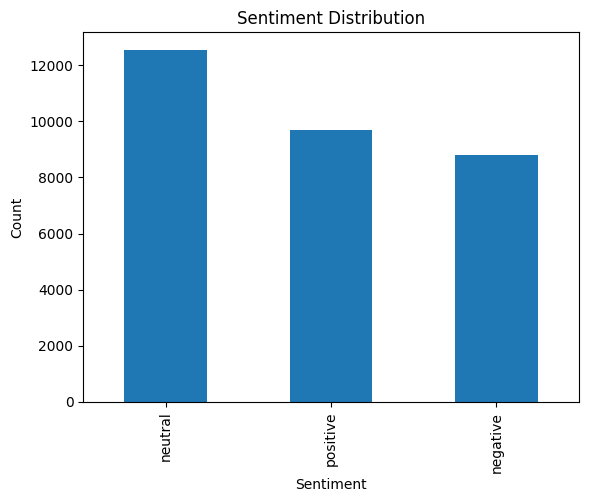

In [120]:
sentiment = df['sentiment'].value_counts()
sentiment.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Text(0, 0.5, 'Count')

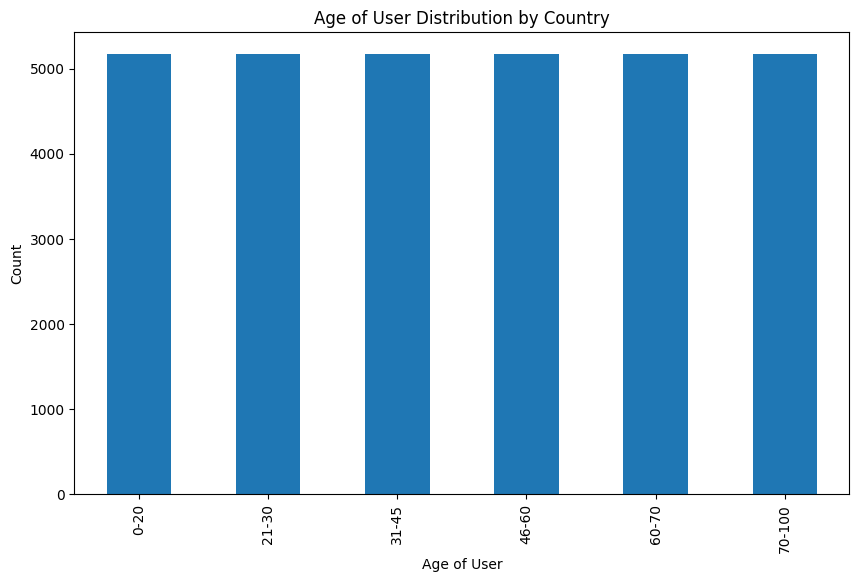

In [121]:
age_of_user_country = df.groupby('Age of User')['Country'].count()
plt.figure(figsize=(10, 6))
age_of_user_country.plot(kind='bar')
plt.title('Age of User Distribution by Country')
plt.xlabel('Age of User')
plt.ylabel('Count')

## Processing the dataset for sequence classification

In [122]:
df.shape

(31014, 16)

In [123]:
df.isna().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0
Time of Tweet,0
Age of User,0
Country,0
Population -2020,0
Land Area (Km²),0
Density (P/Km²),0


In [124]:
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [125]:
df.dropna(inplace=True)

<ipython-input-125-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [126]:
df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
31010,"its at 3 am, im very tired but i can`t sleep ...",negative
31011,All alone in this old house again. Thanks for...,positive
31012,I know what you mean. My little dog is sinkin...,negative
31013,_sutra what is your next youtube video gonna b...,positive


In [127]:
df.duplicated().sum()

np.int64(0)

# Mariam

**LSTM Model**


In [128]:
def clean_text_emotion_aware(text):
    text = str(text)
    text = emoji.demojize(text)

    text = re.sub(r"http\S+|www.\S+", '', text)

    text = re.sub(r'\d+', '', text)

    punctuation_to_keep = "!?."
    punctuation_to_remove = ''.join(ch for ch in string.punctuation if ch not in punctuation_to_keep)
    text = text.translate(str.maketrans('', '', punctuation_to_remove))

    text = text.replace(":", " ")

    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()

    return text

In [129]:
df['clean_text'] = df['text'].apply(clean_text_emotion_aware)

In [130]:
df['clean_text'].head(3)

,clean_text
0,id have responded if i were going
1,sooo sad i will miss you here in san diego!!!
2,my boss is bullying me...


In [131]:
# دي النسخه الاصليه بتاعت الداتا اللي انتو هتشتغلوا عليها عادي , انا شغاله ع النشخه اللي معمول ليها cleaning
df['text'].head(3)

,text
0,"I`d have responded, if I were going"
1,Sooo SAD I will miss you here in San Diego!!!
2,my boss is bullying me...


In [132]:
vocab_size = 10000
max_len = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

In [133]:
X = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(X, padding='post', maxlen=max_len)

In [134]:
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [136]:
X_train

array([[1122,  170,    8, ...,    0,    0,    0],
       [   2,   89,  127, ...,    0,    0,    0],
       [  49,  589,   34, ...,    0,    0,    0],
       ...,
       [1411,    7, 4878, ...,    0,    0,    0],
       [   5,   12, 2535, ...,    0,    0,    0],
       [5485,   43,    4, ...,    0,    0,    0]], dtype=int32)

In [137]:
num_classes = len(np.unique(y_train))
num_classes

3

In [138]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-05-12 18:14:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-12 18:14:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-12 18:14:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [139]:
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [140]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [141]:
model_2 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],  # استخدمنا وزن GloVe
              trainable=False),            # ما يدربش الـ embedding
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [142]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=256, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
    ])

In [143]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [144]:
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [145]:
class MetricCapturingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_metrics = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_metrics.append(logs)

# Initialize the callback to capture metrics
metric_callback = MetricCapturingCallback()

In [146]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [147]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=64,
    callbacks=[early_stopping, metric_callback]
)

Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5081 - loss: 0.9701 - val_accuracy: 0.7105 - val_loss: 0.6944
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7710 - loss: 0.5900 - val_accuracy: 0.7048 - val_loss: 0.6981


In [148]:
history = model_2.fit(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=16,
    callbacks=[early_stopping, metric_callback]
)

Epoch 1/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5374 - loss: 0.9469 - val_accuracy: 0.6974 - val_loss: 0.7278
Epoch 2/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6874 - loss: 0.7367 - val_accuracy: 0.7113 - val_loss: 0.7104
Epoch 3/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7075 - loss: 0.6964 - val_accuracy: 0.7125 - val_loss: 0.6798
Epoch 4/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7206 - loss: 0.6579 - val_accuracy: 0.7250 - val_loss: 0.6667
Epoch 5/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7384 - loss: 0.6223 - val_accuracy: 0.7264 - val_loss: 0.6693


## Split the Dataset into train and test

In [149]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [150]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

#BERT

##Malak and Mariam

## Text Preprocessing using BERT

In [151]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='tf')
train_encodings

{'input_ids': <tf.Tensor: shape=(24811, 110), dtype=int32, numpy=
array([[ 101, 1001, 3582, ...,    0,    0,    0],
       [ 101, 1045, 3335, ...,    0,    0,    0],
       [ 101, 2064, 1036, ...,    0,    0,    0],
       ...,
       [ 101, 8299, 1024, ...,    0,    0,    0],
       [ 101, 1037, 1009, ...,    0,    0,    0],
       [ 101, 6249, 2293, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(24811, 110), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(24811, 110), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [152]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                        num_labels=len(y_test.unique()),
                                                        hidden_dropout_prob=0.3,
                                                        attention_probs_dropout_prob=0.3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [153]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [154]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_encoded
)).batch(16)

In [155]:
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='tf')
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_encoded
)).batch(16)

In [156]:
# Create a callback to capture metrics during training
class MetricCapturingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_metrics = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_metrics.append(logs)

# Initialize the callback to capture metrics
metric_callback = MetricCapturingCallback()

In [157]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [158]:
# Train the model and capture history
history = model.fit(
    train_dataset,
    epochs=4,
    validation_data=test_dataset,
    callbacks=[early_stopping, metric_callback]
)

Epoch 1/4
1551/1551 [==============================] - 158s 76ms/step - loss: 0.6412 - accuracy: 0.7329 - val_loss: 0.5153 - val_accuracy: 0.7849
Epoch 2/4
1551/1551 [==============================] - 102s 66ms/step - loss: 0.5231 - accuracy: 0.7903 - val_loss: 0.5272 - val_accuracy: 0.7909


In [159]:
# Evaluate the model
eval_results = model.evaluate(test_dataset)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")

388/388 [==============================] - 9s 23ms/step - loss: 0.5153 - accuracy: 0.7849
Test Loss: 0.5153310298919678, Test Accuracy: 0.7849427461624146


### Saving the model

In [160]:
model.save_pretrained('/content/drive/MyDrive/sentiment_analysis_model')
tokenizer.save_pretrained('/content/drive/MyDrive/sentiment_analysis_model')

('/content/drive/MyDrive/sentiment_analysis_model/tokenizer_config.json',
 '/content/drive/MyDrive/sentiment_analysis_model/special_tokens_map.json',
 '/content/drive/MyDrive/sentiment_analysis_model/vocab.txt',
 '/content/drive/MyDrive/sentiment_analysis_model/added_tokens.json')

##loading model

In [161]:
model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/sentiment_analysis_model")
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/sentiment_analysis_model")

Some layers from the model checkpoint at /content/drive/MyDrive/sentiment_analysis_model were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/sentiment_analysis_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


### Using the model for inference

In [162]:
predictions = model.predict(test_dataset)

predictions

388/388 [==============================] - 12s 24ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 2.846306  , -0.69606173, -1.9385325 ],
       [-1.0769926 ,  2.2213967 , -1.1093665 ],
       [ 3.0120409 , -0.6136686 , -2.137981  ],
       ...,
       [ 1.6473496 , -0.31543723, -1.6964601 ],
       [ 1.392138  , -0.14016913, -1.5484419 ],
       [-2.993216  , -0.07699473,  2.6245737 ]], dtype=float32), hidden_states=None, attentions=None)

In [163]:
class_indices = np.argmax(predictions.logits, axis=1)
class_indices

array([0, 1, 0, ..., 0, 0, 2])

In [164]:
y_test_decoded = le.inverse_transform(y_test_encoded)
y_pred_decoded = le.inverse_transform(class_indices)

In [165]:
results_df = pd.DataFrame({
    'text': X_test.values,
    'actual_sentiment': y_test_decoded,
    'predicted_sentiment': y_pred_decoded
})

results_df.head()

,text,actual_sentiment,predicted_sentiment
0,I was afraid you were going to say that.,negative,negative
1,part 2: social networking??.. there is even r...,neutral,neutral
2,i miss the one who would do anything to spend ...,negative,negative
3,tee we beefin....what was u supposed to do b...,neutral,neutral
4,Happy Hug Your Mom Day!! love you mom,positive,positive


In [166]:
print("تقرير التصنيف (Classification Report):")
print(classification_report(y_test_encoded, class_indices, target_names=le.classes_))


report_dict = classification_report(y_test_encoded, class_indices, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df.round(2))

تقرير التصنيف (Classification Report):
              precision    recall  f1-score   support

    negative       0.76      0.82      0.79      1749
     neutral       0.76      0.73      0.75      2502
    positive       0.84      0.82      0.83      1952

    accuracy                           0.78      6203
   macro avg       0.79      0.79      0.79      6203
weighted avg       0.79      0.78      0.78      6203



,precision,recall,f1-score,support
negative,0.76,0.82,0.79,1749.00
neutral,0.76,0.73,0.75,2502.00
positive,0.84,0.82,0.83,1952.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.79,0.79,0.79,6203.00
weighted avg,0.79,0.78,0.78,6203.00


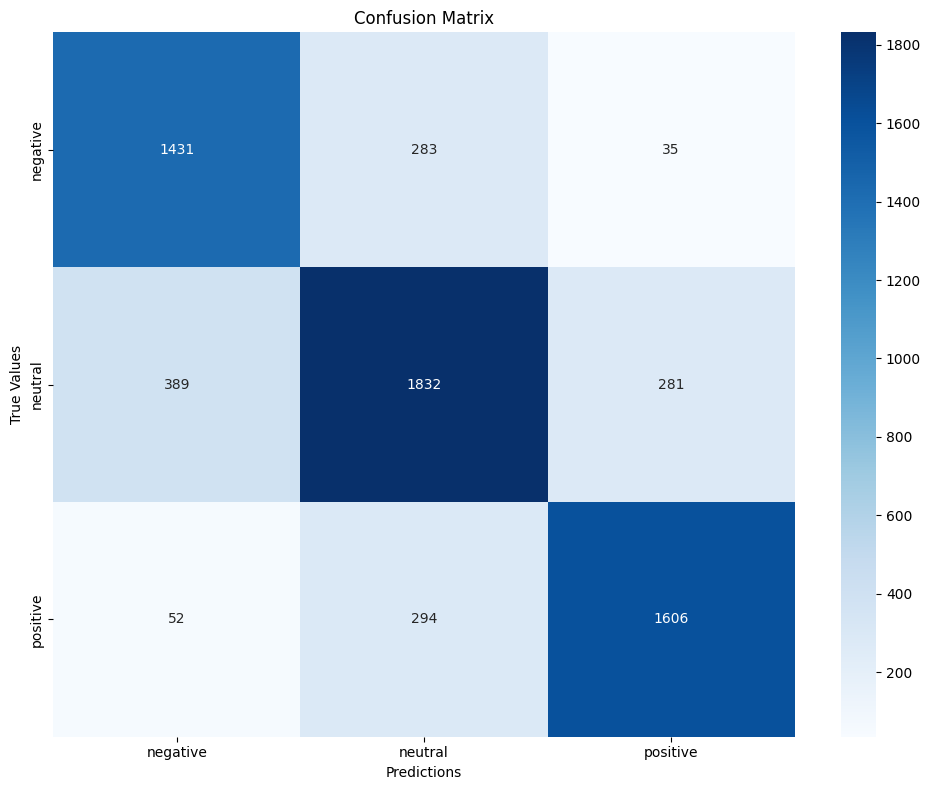

In [167]:
# (Confusion Matrix)
cm = confusion_matrix(y_test_encoded, class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.tight_layout()
plt.show()

In [168]:
# حساب دقة النموذج الإجمالية
accuracy = (cm.diagonal().sum() / cm.sum()) * 100
print(f"total accuracy : {accuracy:.2f}%")

total accuracy : 78.49%


##Marwan

##Gradio UI

In [169]:
le = LabelEncoder()
le.fit(df['sentiment'])

LabelEncoder()

In [170]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = model(inputs)
    pred_class = np.argmax(outputs.logits, axis=1).item()
    sentiment = le.inverse_transform([pred_class])[0]
    return sentiment

interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=4, placeholder="Enter a sentence here..."),
    outputs="text",
    title="Sentiment Classifier",
    description="Model that classifies sentiment using BERT (Fine-tuned)."
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e37b2787ff456785a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


##ML FLOW

In [171]:
#MLflow

# حط هنا التوكن بتاعك بعد ما تعمل اكونت من ngrk
!ngrok config add-authtoken 2wf3BO5M2QXfadRiq2PMQhxWtHY_4D3t4XZRpqsSmxPsMTNpn


mlflow.tensorflow.autolog(disable=True)


EPOCHS = len(metric_callback.epoch_metrics)
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
MODEL_DIR = "/content/drive/MyDrive/sentiment_analysis_model"

# استخراج أفضل قيم acc w loss
best_epoch_idx = np.argmin([metrics.get('val_loss', float('inf')) for metrics in metric_callback.epoch_metrics])
best_epoch_metrics = metric_callback.epoch_metrics[best_epoch_idx]

VAL_ACCURACY = best_epoch_metrics.get('val_accuracy', eval_results[1])  # استخدام نتائج التقييم كبديل إذا لزم الأمر
VAL_LOSS = best_epoch_metrics.get('val_loss', eval_results[0])


TRAINING_ACCURACY = best_epoch_metrics.get('accuracy', None)
TRAINING_LOSS = best_epoch_metrics.get('loss', None)
TEST_ACCURACY = eval_results[1]
TEST_LOSS = eval_results[0]

# تسجيل المعلومات مع MLflow
with mlflow.start_run(run_name="bert_sentiment_analysis"):
    # تسجيل البارامترز
    mlflow.log_param("epochs_trained", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("model_type", "bert-base-uncased")
    mlflow.log_param("num_labels", len(y_test.unique()))
    mlflow.log_param("hidden_dropout_prob", 0.3)
    mlflow.log_param("attention_probs_dropout_prob", 0.3)

    # تسجيل المقاييس
    mlflow.log_metric("best_val_accuracy", VAL_ACCURACY)
    mlflow.log_metric("best_val_loss", VAL_LOSS)
    mlflow.log_metric("test_accuracy", TEST_ACCURACY)
    mlflow.log_metric("test_loss", TEST_LOSS)

    if TRAINING_ACCURACY is not None:
        mlflow.log_metric("training_accuracy", TRAINING_ACCURACY)
    if TRAINING_LOSS is not None:
        mlflow.log_metric("training_loss", TRAINING_LOSS)


    for epoch, metrics in enumerate(metric_callback.epoch_metrics):
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(f"epoch_{epoch+1}_{metric_name}", metric_value)


    if os.path.exists(MODEL_DIR):
        mlflow.log_artifacts(MODEL_DIR, artifact_path="bert_model")


    mlflow.tensorflow.log_model(model, "bert_model_direct")

# معلومات الدنيا دي
print("✅ MLflow Run completed successfully!")
print(f"📊 Metrics logged: val_accuracy={VAL_ACCURACY:.4f}, val_loss={VAL_LOSS:.4f}, test_accuracy={TEST_ACCURACY:.4f}")
print(f"🔢 Model trained for {EPOCHS} epochs with batch size {BATCH_SIZE}")

# إعداد واجهة MLflow UI
import mlflow
from pyngrok import ngrok

mlflow_port = 5000
mlflow_ui = ngrok.connect(mlflow_port)
print("🔗 MLflow UI:", mlflow_ui)

!mlflow ui --port 5000 --host 0.0.0.0

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


2025/05/12 18:23:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/12 18:24:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLflow Run completed successfully!
📊 Metrics logged: val_accuracy=0.7849, val_loss=0.5153, test_accuracy=0.7849
🔢 Model trained for 2 epochs with batch size 16
🔗 MLflow UI: NgrokTunnel: "https://1b86-34-60-56-19.ngrok-free.app" -> "http://localhost:5000"
[2025-05-12 18:24:14 +0000] [44195] [INFO] Starting gunicorn 23.0.0
[2025-05-12 18:24:14 +0000] [44195] [INFO] Listening at: http://0.0.0.0:5000 (44195)
[2025-05-12 18:24:14 +0000] [44195] [INFO] Using worker: sync
[2025-05-12 18:24:14 +0000] [44196] [INFO] Booting worker with pid: 44196
[2025-05-12 18:24:14 +0000] [44197] [INFO] Booting worker with pid: 44197
[2025-05-12 18:24:14 +0000] [44198] [INFO] Booting worker with pid: 44198
[2025-05-12 18:24:14 +0000] [44199] [INFO] Booting worker with pid: 44199

Aborted!
[2025-05-12 18:25:42 +0000] [44195] [INFO] Handling signal: int
[2025-05-12 18:25:42 +0000] [44197] [INFO] Worker exiting (pid: 44197)
[2025-05-12 18:25:42 +0000] [44199] [INFO] Worker exiting (pid: 44199)
[2025-05-12 18:2

##jana

##TF-IDF and SVM

In [172]:
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('classifier', LinearSVC(C=1, dual=False))
])

In [173]:
start_time = time.time()
print("SVM...")
pipeline_svm.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"training_time :{training_time:.2f} ثانية")

SVM...
training_time :2.54 ثانية


In [174]:
y_pred_svm = pipeline_svm.predict(X_test)

In [175]:
report = classification_report(y_test, y_pred_svm, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(2)
print(classification_report(y_test, y_pred_svm))
display(report_df)

              precision    recall  f1-score   support

    negative       0.67      0.61      0.64      1749
     neutral       0.62      0.66      0.64      2502
    positive       0.74      0.73      0.73      1952

    accuracy                           0.67      6203
   macro avg       0.68      0.67      0.67      6203
weighted avg       0.67      0.67      0.67      6203



,precision,recall,f1-score,support
negative,0.67,0.61,0.64,1749.00
neutral,0.62,0.66,0.64,2502.00
positive,0.74,0.73,0.73,1952.00
accuracy,0.67,0.67,0.67,0.67
macro avg,0.68,0.67,0.67,6203.00
weighted avg,0.67,0.67,0.67,6203.00


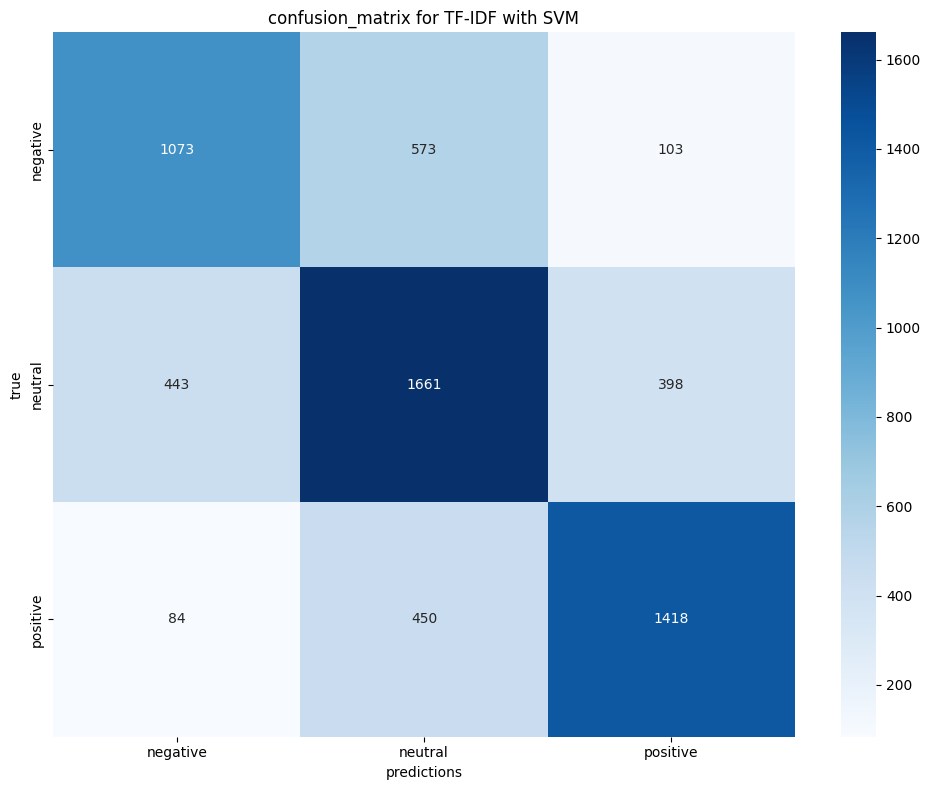

In [176]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("confusion_matrix for TF-IDF with SVM")
plt.xlabel("predictions")
plt.ylabel("true")
plt.tight_layout()
plt.show()

#Rondom forest

In [177]:
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [178]:
start_time = time.time()
print("Random Forest...")
pipeline_rf.fit(X_train, y_train)
rf_training_time = time.time() - start_time
print(f"training_time:{rf_training_time:.2f} ثانية")

Random Forest...
training_time:42.83 ثانية


In [179]:
y_pred_rf = pipeline_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

    negative       0.74      0.54      0.62      1749
     neutral       0.61      0.76      0.68      2502
    positive       0.77      0.73      0.75      1952

    accuracy                           0.69      6203
   macro avg       0.71      0.67      0.68      6203
weighted avg       0.70      0.69      0.69      6203



##Hussam

###Logistic regresion

In [180]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(C=1, max_iter=1000, solver='liblinear'))
])

In [181]:
start_time = time.time()
print("Logistic Regression...")
pipeline_lr.fit(X_train, y_train)
lr_training_time = time.time() - start_time
print(f"training_time :{lr_training_time:.2f} ثانية")

Logistic Regression...
training_time :1.28 ثانية


In [182]:
y_pred_lr = pipeline_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

    negative       0.73      0.57      0.64      1749
     neutral       0.62      0.75      0.68      2502
    positive       0.78      0.71      0.74      1952

    accuracy                           0.69      6203
   macro avg       0.71      0.68      0.69      6203
weighted avg       0.70      0.69      0.69      6203



##Marwan

##Comparison

In [183]:
models = {
    'SVM': (pipeline_svm, y_pred_svm, training_time),
    'Random Forest': (pipeline_rf, y_pred_rf, rf_training_time),
    'Logistic Regression': (pipeline_lr, y_pred_lr, lr_training_time)
}

In [184]:
model_comparison = {
    'name': [],
    'accuracy': [],
    'train_time': []
}

In [185]:
for name, (model, predictions, train_time) in models.items():
    accuracy = accuracy_score(y_test, predictions)
    model_comparison['name'].append(name)
    model_comparison['accuracy'].append(accuracy)
    model_comparison['train_time'].append(train_time)

comparison_df = pd.DataFrame(model_comparison)
display(comparison_df)

,name,accuracy,train_time
0,SVM,0.669354,2.540581
1,Random Forest,0.686603,42.834631
2,Logistic Regression,0.688699,1.275714


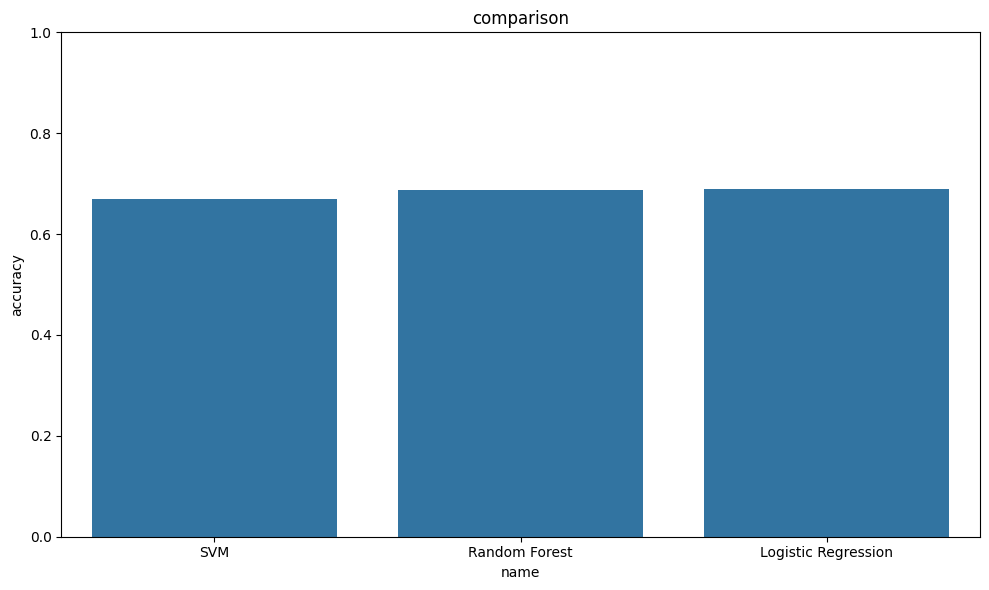

In [186]:
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='accuracy', data=comparison_df)
plt.title('comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [187]:
best_model_name = comparison_df.loc[comparison_df['accuracy'].idxmax(), 'name']
best_model = models[best_model_name][0]

print(f"best_model_name: {best_model_name} with accuracy : {comparison_df['accuracy'].max():.4f}")

best_model_name: Logistic Regression with accuracy : 0.6887


In [188]:
def predict_sentiment(text, model=best_model):
    sentiment = model.predict([text])[0]
    return sentiment

test_examples = [
    "I love this product! It's amazing and works perfectly.",
    "This is the worst experience I've ever had.",
    "The service was okay, nothing special but not bad either.",
    "I'm very disappointed with the quality of this item."
]

for example in test_examples:
    sentiment = predict_sentiment(example)
    print(f"text: {example}")
    print(f"predicted: {sentiment}\n")

text: I love this product! It's amazing and works perfectly.
predicted: positive

text: This is the worst experience I've ever had.
predicted: negative

text: The service was okay, nothing special but not bad either.
predicted: neutral

text: I'm very disappointed with the quality of this item.
predicted: negative



In [189]:
!pip install streamlit

In [190]:
#https://drive.google.com/file/d/1OuN8rzkdaADa0tItgkv3U78KTYSUrNPh/view?usp=sharing
!gdown 1OuN8rzkdaADa0tItgkv3U78KTYSUrNPh

Downloading...
From (original): https://drive.google.com/uc?id=1OuN8rzkdaADa0tItgkv3U78KTYSUrNPh
From (redirected): https://drive.google.com/uc?id=1OuN8rzkdaADa0tItgkv3U78KTYSUrNPh&confirm=t&uuid=2b8c9fb6-a24c-45a8-a686-edf9ca9a8348
To: /content/app.py
100% 726/726 [00:00<00:00, 4.19MB/s]


In [191]:
!streamlit run /content/app.py --server.port 8500




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8500
  Network URL: http://172.28.0.12:8500
  External URL: http://34.60.56.19:8500

  Stopping...
  Stopping...
